In [1]:
import random
import json
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import torch
import optuna
import sklearn.datasets
import sklearn.metrics
import sklearn.preprocessing
import sklearn.model_selection
import nntd

### Global Vars

In [2]:
storage_device = torch.device(0)
training_device = torch.device(0)
seed = 2319
#Needed for notebook reproducibility, nntd.pipeline depends on global seeds
torch.backends.cudnn.benchmark = False 
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
torch.cuda.manual_seed(seed+1)
np.random.seed(seed+2)
random.seed(seed+3)

In [3]:
xgb_hyperparameters_path = 'hyperparameters/example/XGBoost_example_builtin.json'
nn_hyperparameters_path = 'hyperparameters/example/ResNet_PLE_example_augmentation.json'

### Load CA Housing dataset and make splits

In [4]:
task = 'regression'
dataset = sklearn.datasets.fetch_california_housing()

In [5]:
X_dict = {}
y_dict = {}
X_dict['train'], X_dict['test'], y_dict['train'], y_dict['test'] =\
sklearn.model_selection.train_test_split(
    dataset['data'].astype('float32'),
    dataset['target'].astype('float32'),
    train_size = 0.8,
    random_state = seed,
)
X_dict['train'], X_dict['val'], y_dict['train'], y_dict['val'] =\
sklearn.model_selection.train_test_split(
    X_dict['train'],
    y_dict['train'],
    train_size = 0.8,
    random_state = seed+1,
)

### Add some NaNs

In [6]:
p_nan = 0.1
lat_long_idx = [6, 7]#exclude the latitdue and longitude features
rng = np.random.default_rng(seed)
for k, v in X_dict.items():
    nan_mask = rng.uniform(0, 1, v.shape)<p_nan
    nan_mask[:, lat_long_idx]=False
    np.putmask(v, nan_mask, np.nan)

### Preprocessing + dataset creation

In [7]:
if task=='regression':
    y_mean = y_dict['train'].mean()
    y_std = y_dict['train'].std()
    y_dict = {k: (v - y_mean) / y_std for k, v in y_dict.items()}

In [8]:
#Quantile transform for numerical features
qt = sklearn.preprocessing.QuantileTransformer(random_state = seed).fit(X_dict['train'])
train_dataset = nntd.TabularDataset(
    X_num = qt.transform(X_dict['train']),
    X_cat = None,
    y = y_dict['train'],
    cardinalities = [],
    device = storage_device,
)
val_dataset, test_dataset = [
    nntd.TabularDataset(
        X_num = qt.transform(X_dict[part]),
        X_cat = None,
        y = y_dict[part],
        cardinalities = [],
        device = storage_device,
    )
    for part in ['val', 'test']
]
#This dataset has no categoricals. Any categoricals are passed as X_cat above. The values need to be ints from 0 to n_classes-1.
#The cardinalities argument should be a list [n_1, n_2, ...] where n_i is the number of classes of categorical feature i

In [9]:
#DMatrix for XGBoost baseline
d_dict = {k:xgboost.DMatrix(v, label = y_dict[k]) for k,v in X_dict.items()}

### Evaluation Functions

In [10]:
if task=='binclass':
    val_metric = lambda y, yhat: sklearn.metrics.log_loss(y, yhat, eps = 1e-6)
    display_metric = lambda y, yhat: sklearn.metrics.roc_auc_score(y, yhat)
elif task=='regression':
    val_metric = lambda y, yhat: sklearn.metrics.mean_squared_error(y, yhat)
    display_metric = lambda y, yhat: y_std*np.sqrt(np.mean((yhat-y)**2))

### XGBoost Baseline

In [11]:
def params_from_trial(trial):
    hyperparameters = {
        'params':{
            'objective':'binary:logistic' if task=='binclass' else 'reg:squarederror',
            'learning_rate':trial.suggest_float('learning_rate', 0.005, 0.3, log = True),
            'max_depth':trial.suggest_int('max_depth', 3, 10),
            'lambda':trial.suggest_float('lambda', 1e-3, 1e2, log=True),
            'gamma':trial.suggest_float('gamma', 1e-3, 1e2, log=True),
            'subsample':trial.suggest_float('subsample', 0.4, 1.0),
            'colsample_bytree':trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'min_child_weight':trial.suggest_float('min_child_weight', 1, 1e2),
            'tree_method':'gpu_hist',
            'seed':seed,
            'eval_metric':'logloss',
        },
        'num_boost_round':2000,
        #'early_stopping_rounds':100,
    }
    return hyperparameters

def objective(trial):
    hyperparameters = params_from_trial(trial)
    bst = xgboost.train(
        hyperparameters['params'],
        d_dict['train'],
        num_boost_round = hyperparameters['num_boost_round'],
        #early_stopping_rounds = params['early_stopping_rounds'],
        #evals = [(d_dict['val'], 'eval')],
        #verbose_eval = False,
    )
    score = val_metric(y_dict['val'], bst.predict(d_dict['val']))
    return score

#Uncomment to run hyperparameter optimization
#study = optuna.create_study(direction='minimize', study_name='XGBoost')
#study.optimize(objective, n_trials=100)
#xgb_hyperparameters = params_from_trial(study.best_trial)
with open(xgb_hyperparameters_path, 'r') as file:
    xgb_hyperparameters = json.load(file)

In [12]:
bst = xgboost.train(
    xgb_hyperparameters['params'],
    d_dict['train'],
    num_boost_round = xgb_hyperparameters['num_boost_round'],
)
print(display_metric(y_dict['val'], bst.predict(d_dict['val'])))

0.46585992


### ResNet

### Unified Optimization

In [13]:
def params_from_trial(trial):
    model_params = {
    'encoder_name':'PiecewiseLinearEncoder',
    'encoder_params':{
        'd_encoding':trial.suggest_int('d_encoding', 32, 64),
    },
    'd_num':trial.suggest_int('d_encoding', 32, 64),
    'd_cat':None,
    'dropout_input':trial.suggest_float('dropout_input', 0.0, 0.3),
    'backbone_name':'ResNet',
    'backbone_params':{
        'd_main':trial.suggest_int('d_main', 64, 128),
        'n_blocks':1,
        'dropout_first':trial.suggest_float('dropout_first', 0.0, 0.3),
        'dropout_second':0.0,
    }
    }
    model_params['backbone_params']['d_hidden'] \
        = int(model_params['backbone_params']['d_main']*trial.suggest_float('d_hidden_factor', 2, 5))
    optimizer_params = {
        'weight_decay':trial.suggest_float('weight_decay', 1e-2, 3e-1, log = True),
        'betas':(0.9, 0.98),
    }
    batch_size = 256
    epochs = 60
    scheduler_params = {
        'total_steps':int(np.floor(len(X_dict['train'])/batch_size)*epochs),
        'max_lr':trial.suggest_float('max_lr', 1e-3, 3e-2, log = True),
        'pct_start':trial.suggest_float('pct_start', 0.3, 0.7),
        'anneal_strategy':'linear',
        'cycle_momentum':True,
        'base_momentum':0.85,
        'max_momentum':0.9,
        'div_factor':trial.suggest_float('div_factor', 5, 20),
        'final_div_factor':trial.suggest_float('final_div_factor', 5, 20),
    }
    hyperparameters = {
        'model_params':model_params,
        'optimizer_params':optimizer_params,
        'task_type':task,
        'batch_size':batch_size,
        'epochs':epochs,
        'seed':seed,
        'scheduler_name':'OneCycleLR',
        'scheduler_params':scheduler_params,
    }
    return hyperparameters

def objective(trial):
    tracker = nntd.ProgressTracker(15, val_dataset, val_metric = val_metric)
    pipeline = nntd.FeatureEmbeddingPipeline(**params_from_trial(trial), training_device = training_device)
    pipeline.train(train_dataset, tracker = tracker)
    return tracker.score

#Uncomment to run hyperparameter optimization
#study = optuna.create_study(direction='minimize', study_name='ResNet_PLE')
#study.optimize(objective, n_trials=100)
#nn_hyperparameters = params_from_trial(study.best_trial)
with open(nn_hyperparameters_path, 'r') as file:
    nn_hyperparameters = json.load(file)
nn_hyperparameters['augmentation_params'] = {'p_nan':[0.15]*6+[0, 0]}

### Optimized Run

In [14]:
tracker = nntd.ProgressTracker(15, val_dataset, val_metric = val_metric, verbose = True)
pipeline = nntd.FeatureEmbeddingPipeline(**nn_hyperparameters, training_device = training_device)
pipeline.train(train_dataset, tracker = tracker)
score = display_metric(y_dict['val'], pipeline.predict(val_dataset.X))
print(f'Validation Loss:', score)

Epoch 15: 0.2528
Epoch 30: 0.2075
Epoch 45: 0.1832
Epoch 60: 0.1582
Validation Loss: 0.4498576


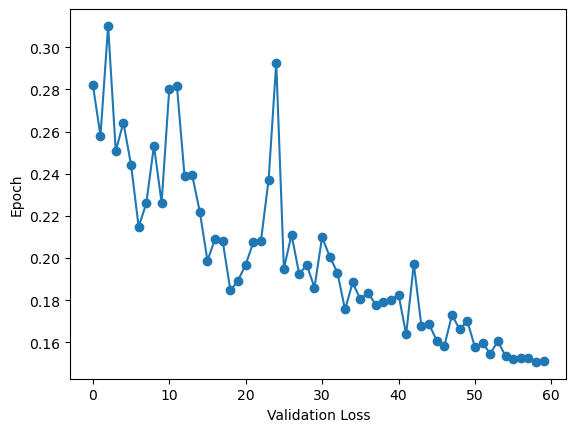

In [15]:
tracker.plot_losses()

### Test set evaluation

In [16]:
yhat_test_nn =  pipeline.predict(test_dataset.X)
yhat_test_xgb =  bst.predict(d_dict['test'])
print('XGBoost', display_metric(y_dict['test'], yhat_test_xgb))
print('NN', display_metric(y_dict['test'], yhat_test_nn))
print('Naive Ensemble', display_metric(y_dict['test'], 0.5*(yhat_test_nn+yhat_test_xgb)))

XGBoost 0.4592323
NN 0.45234123
Naive Ensemble 0.44119498


### Multi-seed test-set evaluation

In [17]:
rng = np.random.default_rng(seed = seed)
seeds = rng.integers(1, 1e6, 5)

In [18]:
nns = {}
for i, new_seed in enumerate(seeds):
    hyperparameters = deepcopy(nn_hyperparameters)
    hyperparameters['seed'] = new_seed
    tracker = nntd.ProgressTracker(15, val_dataset, val_metric = val_metric, verbose = False)
    pipeline = nntd.FeatureEmbeddingPipeline(**hyperparameters, training_device = training_device)
    pipeline.train(train_dataset, tracker = tracker)
    predictions =  pipeline.predict(test_dataset.X)
    nns[new_seed]={
        'pipeline':pipeline,
        'score':display_metric(y_dict['test'], predictions),
        'predictions':predictions
    }
    print(f'NN Run {i} score: ', nns[new_seed]['score'])
print('Average Score:', np.mean([v['score'] for k, v in nns.items()]))
nn_ensemble_predictions = np.mean(
    np.concatenate([v['predictions'][..., None] for k, v in nns.items()], axis = 1),
    axis = 1,
)
ensemble_score = display_metric(y_dict['test'], nn_ensemble_predictions)
print(f'Ensemble Score: {ensemble_score}')

NN Run 0 score:  0.4566022
NN Run 1 score:  0.4572921
NN Run 2 score:  0.45573536
NN Run 3 score:  0.45496106
NN Run 4 score:  0.45243382
Average Score: 0.4554049
Ensemble Score: 0.4471714496612549


In [19]:
bsts = {}
for i, new_seed in enumerate(seeds):
    hyperparameters = deepcopy(xgb_hyperparameters)
    hyperparameters['params']['seed'] = new_seed
    bst = xgboost.train(
        hyperparameters['params'],
        d_dict['train'],
        num_boost_round = hyperparameters['num_boost_round']
    )
    predictions =  bst.predict(d_dict['test'])
    bsts[new_seed]={
        'booster':bst,
        'score':display_metric(y_dict['test'], predictions),
        'predictions':predictions,
    }
    print(f'XGBoost Run {i} score: ', bsts[new_seed]['score'])
print('Average Score:', np.mean([v['score'] for k, v in bsts.items()]))
xgb_ensemble_predictions = np.mean(
    np.concatenate([v['predictions'][..., None] for k, v in bsts.items()], axis = 1),
    axis = 1,
)
ensemble_score = display_metric(y_dict['test'], xgb_ensemble_predictions)
print(f'Ensemble Score: {ensemble_score}')

XGBoost Run 0 score:  0.4618656
XGBoost Run 1 score:  0.4599168
XGBoost Run 2 score:  0.4599118
XGBoost Run 3 score:  0.45870143
XGBoost Run 4 score:  0.46205187
Average Score: 0.4604895
Ensemble Score: 0.4584796726703644


In [20]:
display_metric(y_dict['test'], 0.5*(nn_ensemble_predictions+xgb_ensemble_predictions))

0.44011348